In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
plt.style.use('~/line_plot.mplstyle')
import json, os, pickle
from scipy.signal import argrelmin
from pathlib import Path

C6 = 2 * np.pi * .862690

In [2]:
def generate_sites_lieb_lattice(n_x, n_y, include_last_column=True):
    # n_x and n_y are unit cells of the Lieb lattice, not rows and columns
    sites = []

    x_ind = 0
    y_ind = 0

    for ii in range(n_x):
        x_ind += 1

        for jj in range(n_y):
            y_ind += 1
            sites.append([x_ind, y_ind])
            y_ind += 1
            sites.append([x_ind, y_ind])

        x_ind += 1
        y_ind -= 1

        for jj in range(n_y):
            sites.append([x_ind, y_ind])
            y_ind -= 2

        y_ind += 1

    if include_last_column:
        x_ind += 1

        for jj in range(n_y):
            y_ind += 1
            sites.append([x_ind, y_ind])
            y_ind += 1
            sites.append([x_ind, y_ind])

    return sites

def generate_bc_sites_lieb_lattice(n_x, n_y, include_last_column=True):
    # n_x and n_y are unit cells of the Lieb lattice, not rows and columns
    sites = []

    x_ind = 0
    y_ind = 0

    for ii in range(n_x):
        x_ind += 1

        for jj in range(n_y):
            y_ind += 1
            # sites.append([x_ind, y_ind])
            y_ind += 1
            sites.append([x_ind, y_ind])

        x_ind += 1
        y_ind -= 1

        for jj in range(n_y):
            sites.append([x_ind, y_ind])
            y_ind -= 2

        y_ind += 1

    if include_last_column:
        x_ind += 1

        for jj in range(n_y):
            y_ind += 1
            # sites.append([x_ind, y_ind])
            y_ind += 1
            sites.append([x_ind, y_ind])

    return sites

def bc_mag(n_x, n_y, density):
    sites = generate_sites_lieb_lattice(n_x, n_y)
    bc_sites = generate_bc_sites_lieb_lattice(n_x, n_y)
    
    bc_site_inds = []

    for ii in range(len(sites)):
        if sites[ii] in bc_sites:
            bc_site_inds.append(ii)
    
    op = 0
    
    for ind in bc_site_inds:
        op += density[ind]
        
    return op / (3 * len(sites))

In [5]:
data_dir = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/data/lieb/local_detuning_19x10/phase_diagram_data"

f_names = os.listdir(data_dir)

deltas = []
delta_locals = []
ops = []
ent_entropies = []

for f_name in f_names:

    with open(Path(data_dir, f_name), 'r') as f:
        data_dict = json.load(f)

    n_x = data_dict["params"]["ham_config"]["n_x"]
    n_y = data_dict["params"]["ham_config"]["n_y"]
    
    deltas.append(data_dict["params"]["ham_config"]["delta"])
    delta_locals.append(data_dict["params"]["ham_config"]["delta_local"])
    
    ops.append(bc_mag(n_x, n_y, data_dict["results"]["rydberg_density"]))
    ent_entropies.append(data_dict["results"]["entanglement_entropy"])

rb = data_dict["params"]["ham_config"]["Rb"]
n_delta = len(set(deltas))
n_delta_local = len(set(delta_locals))

deltas = np.array(deltas)
delta_locals = np.array(delta_locals)
ops = np.array(ops)
ent_entropies = np.array(ent_entropies)

sites = generate_sites_lieb_lattice(n_x, n_y)

delta_inds = deltas.argsort()

deltas = deltas[delta_inds[::1]]
delta_locals = delta_locals[delta_inds[::1]]
ops = ops[delta_inds[::1]]
ent_entropies = ent_entropies[delta_inds[::1]]

deltas = np.reshape(deltas, (n_delta, n_delta_local))
delta_locals = np.reshape(delta_locals, (n_delta, n_delta_local))
ops = np.reshape(ops, (n_delta, n_delta_local))
ent_entropies = np.reshape(ent_entropies, (n_delta, n_delta_local))

for ii in range(n_delta):
    delta_local_inds = delta_locals[ii].argsort()

    deltas[ii] = deltas[ii][delta_local_inds[::1]]
    delta_locals[ii] = delta_locals[ii][delta_local_inds[::1]]
    ops[ii] = ops[ii][delta_local_inds[::1]]
    ent_entropies[ii] = ent_entropies[ii][delta_local_inds[::1]]

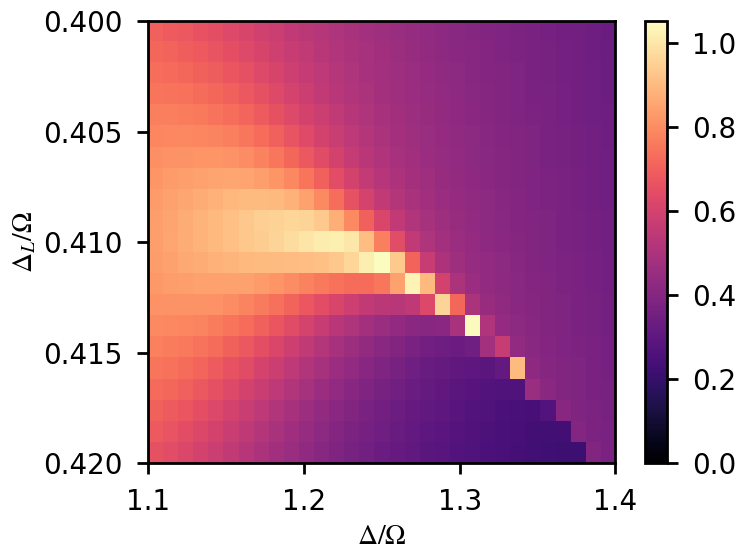

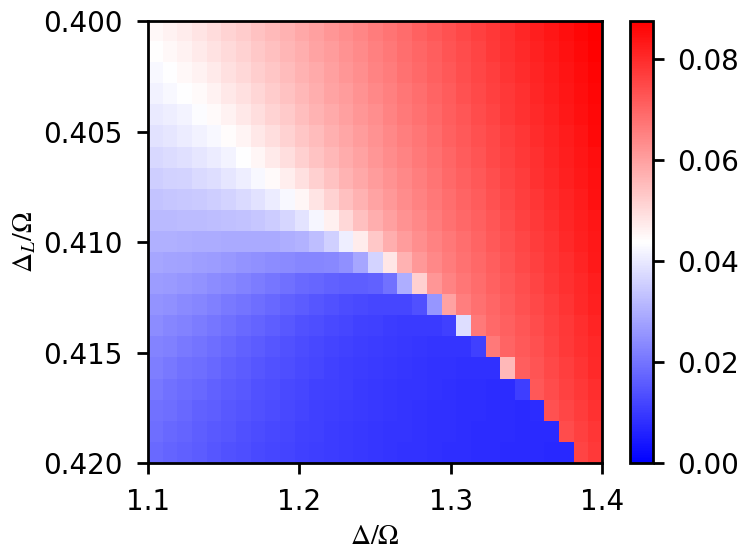

In [25]:
min_y_ind = 10

fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(ent_entropies[:, min_y_ind:].T, cmap="magma", origin='upper', aspect='auto', extent=(np.min(deltas), np.max(deltas), np.max(delta_locals[:, min_y_ind:]), np.min(delta_locals[:, min_y_ind:])), vmin=0)
fig.colorbar(im)

ax.set_xlabel(r'$\Delta/\Omega$')
ax.set_ylabel(r'$\Delta_L/\Omega$')

plt.tight_layout()

plt.show()

###

fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(ops[:, min_y_ind:].T, cmap="bwr", origin='upper', aspect='auto', extent=(np.min(deltas), np.max(deltas), np.max(delta_locals[:, min_y_ind:]), np.min(delta_locals[:, min_y_ind:])), vmin=0)
fig.colorbar(im)

ax.set_xlabel(r'$\Delta/\Omega$')
ax.set_ylabel(r'$\Delta_L/\Omega$')

plt.tight_layout()

plt.show()

In [12]:
def plot_density(delta, delta_local):
    data_dir = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/data/lieb/local_detuning_19x10/phase_diagram_data/"

    f_name = data_dir + "1.2_" + str(delta) + "_" + str(delta_local) + ".json"

    with open(f_name, "rb") as io:
        data_dict = json.load(io)

    n_x = data_dict["params"]["ham_config"]["n_x"]
    n_y = data_dict["params"]["ham_config"]["n_y"]
    delta = data_dict["params"]["ham_config"]["delta"]
    delta_local = data_dict["params"]["ham_config"]["delta_local"]

    density = np.array(data_dict["results"]["rydberg_density"])

    sites = generate_sites_lieb_lattice(n_x, n_y) # old lattice enumeration
    # sites, sublattice_inds, unit_cell_inds = lieb_lattice(n_x, n_y, 1) # new lattice enumeration
    
    xs = [site[0] for site in sites]
    ys = [site[1] for site in sites]
    
    dmax = np.max(density)
    
    fig, ax = plt.subplots(figsize=(6, 3))

    im = ax.scatter(xs, ys, s=70, c=density, vmin=0, vmax=dmax, cmap='viridis')

    ax.set_xticks(())
    ax.set_xmargin(0.05)

    ax.set_yticks(())
    ax.set_ymargin(0.1)

    aspect = 20
    pad_fraction = 1.0
    divider = make_axes_locatable(ax)
    width = axes_size.AxesY(ax, aspect=1./aspect)
    pad = axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    cbar = plt.colorbar(im, cax=cax)

    cbar.ax.set_yticks([0, dmax])
    cbar.ax.set_yticklabels([r"$0$", f"${dmax:.2f}$"])

    plt.tight_layout()
    plt.show()

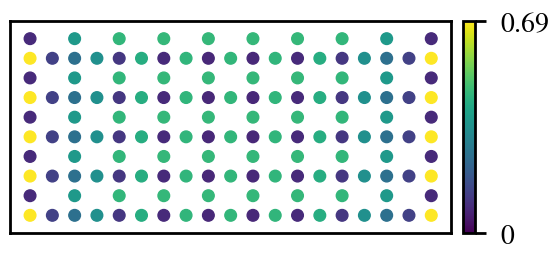

In [15]:
plot_density(1.3, 0.39)